### Initialise Notebook

In [1]:
import pprint
import time as t
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [2]:
def flatten(inp):
    """Takes a list of lists and/or elements, and flattens it into a single list of values."""
    out = []
    for element in inp:
        if type(element) == float or type(element) == int:
            out.append(element)
        if type(element) == list:
            for value in element:
                out.append(value)             
    return out

def plot_confusion_matrix(ypred, ytrue, target_names = ['True','False'],
                          filename = 'temp', cmap = None, 
                          normalize = False, save = False):
    
    """Takes a confusion matrix (or any array) and plots it nicely."""
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, f1_score

    
    
    cm = confusion_matrix(ytrue,ypred)
    accuracy = np.trace(cm) / float(np.sum(cm))
    fscore = f1_score(ytrue, ypred, average='macro')
    kappa = cohen_kappa_score(ytrue,ypred)
    
    print(classification_report(ytrue,ypred,digits=4))
    print(f"Kappa\t{kappa:.4f}")

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cMatrix_temp = []
        for row in cm:
            cMatrix_temp.append( row.astype(float) / sum(row).astype(float) )
        cMatrix_temp = np.round(np.array(cMatrix_temp),3)
        cm = cMatrix_temp

        plt.figure(figsize = (8, 6))
        plt.imshow(cm, interpolation = 'nearest', cmap = cmap, vmax=1)
    
    else: 
        plt.figure(figsize = (8, 6))
        plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
        
    plt.title(f"Confusion Matrix for '{filename}'")
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation = 0)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('<True Label>')
    plt.xlabel('<Prediction>\nAccuracy={:0.4f}; F1 Score={:0.4f}; Kappa={:0.4f}'.format(accuracy, fscore, kappa))
    if save == True:
        plt.savefig(f'{filename}_cnfmtx.png')
    plt.show()

## Data Preprocessing

In [3]:
classes_b  = ['vegetation','non-veg']
classes_c0 = ['cashew','non-plantation']
classes_c1 = ['unknown','residential','background']
classes = ['cashew','non-plantation','unknown','residential','background']

# below are used for naming outputs and version control
root   = 'Cashew_Benin_2022_CNN_Eoin'
ver    = 0
subver = 1
num_bands = 12

In [9]:
##### 0. Load in dataset via CSV file #####
df = pd.read_csv(r'20220203_Cashews_Beni_training_1cashewclass.csv')

In [42]:
df = df.groupby('fid').mean().reset_index()
cols = df.columns.tolist()
df["new_label"].value_counts()

df = df.loc[df["new_label"] != 0]

In [43]:
##### 1. Average over each field #####
df = df.groupby('fid').mean().reset_index()    # hash this out to train on all pixels instead of taking mean-per-field
cols = df.columns.tolist()

##### 2. Split into Training, Testing & Validation <70:20:10> #####
temp, xVal = train_test_split(df, test_size=0.10)
xTrain, xTest = train_test_split(temp, test_size=2/9)

#yTrain, yTest, yVal = xTrain["label"], xTest["label"], xVal["label"]     # good cashew & bad cashew not merged
yTrain, yTest, yVal = xTrain["new_label"], xTest["new_label"], xVal["new_label"]    # good cashew & bad cashew merged

xTrain = xTrain.drop(columns=['label', 'fid', 'row_loc', 'col_loc', 'tile', 'new_label'])
xTest  = xTest.drop(columns=['label', 'fid', 'row_loc', 'col_loc', 'tile', 'new_label'])
xVal   = xVal.drop(columns=['label', 'fid', 'row_loc', 'col_loc', 'tile', 'new_label'])

##### 3. Convert from pd.Dataframe to np.array #####
xTrain = xTrain.to_numpy()
xTest  = xTest.to_numpy()
xVal   = xVal.to_numpy()

yTrain = yTrain.to_numpy()
yTest  = yTest.to_numpy()
yVal   = yVal.to_numpy()

print(xTrain.shape,yTrain.shape)
print(xTest.shape,yTest.shape)
print(xVal.shape,yVal.shape,'\n')

##### 4. Subtract one from every label, to start with label '0' #####
print("The initial training labels were:   \t",np.unique(yTrain))
yTrain = yTrain - 1
print("The edited training labels are:   \t",np.unique(yTrain))

print("The initial testing labels were:   \t",np.unique(yTest))
yTest = yTest - 1
print("The edited testing labels are:   \t",np.unique(yTest))

print("The initial validation labels were:   \t",np.unique(yVal))
yVal = yVal - 1
print("The edited validation labels are:   \t",np.unique(yVal),'\n')

##### 5. Check frequencies of each class #####
(unique, counts) = np.unique(yTrain, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print('Frequencies (training): \n',frequencies,'\n')

##### 6. Reshape datasets #####
num_dates = int( xTrain.shape[1] / 12 )
xTrain    = np.reshape(xTrain, (xTrain.shape[0], num_dates, 12))
xTest     = np.reshape(xTest , (xTest.shape[0] , num_dates, 12))
xVal      = np.reshape(xVal  , (xVal.shape[0]  , num_dates, 12))

print("xTrain shape: \t",xTrain.shape)
print("xTest shape: \t",xTest.shape)
print("xVal shape: \t",xVal.shape,'\n')

##### 7. Assign weightings to classes #####
num_classes = len(np.unique(yTrain))
class_weights = compute_class_weight('balanced', np.unique(yTrain), yTrain)
class_weights = {i : class_weights[i] for i in range(num_classes)}
print("Class Weights:")
pprint.pprint(class_weights)

(1260, 204) (1260,)
(360, 204) (360,)
(181, 204) (181,) 

The initial training labels were:   	 [1. 2. 3. 4. 5.]
The edited training labels are:   	 [0. 1. 2. 3. 4.]
The initial testing labels were:   	 [1. 2. 3. 4. 5.]
The edited testing labels are:   	 [0. 1. 2. 3. 4.]
The initial validation labels were:   	 [1. 2. 3. 4. 5.]
The edited validation labels are:   	 [0. 1. 2. 3. 4.] 

Frequencies (training): 
 [[  0. 709.]
 [  1. 323.]
 [  2.  74.]
 [  3. 110.]
 [  4.  44.]] 

xTrain shape: 	 (1260, 17, 12)
xTest shape: 	 (360, 17, 12)
xVal shape: 	 (181, 17, 12) 

Class Weights:
{0: 0.3554301833568406,
 1: 0.7801857585139319,
 2: 3.4054054054054053,
 3: 2.290909090909091,
 4: 5.7272727272727275}


C:\Users\eoin\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1. 2. 3. 4.], y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


#### 8. Normalise Dataset 

In [44]:
### By Band ###

xTrain = xTrain.astype(float)
xTest  = xTest.astype(float)
xVal   = xVal.astype(float)

for i in range(len(xTrain[0][0])):     # for each band
    max_value = float(max( xTrain[:,:,i].max(), xTest[:,:,i].max(), xVal[:,:,i].max() ))
    xTrain[:,:,i] /= max_value
    xTest[:,:,i]  /= max_value
    xVal[:,:,i]   /= max_value

#### OR

In [ ]:
### All at once ###

max_value = float(max( [xTrain.max(), xTest.max(), xVal.max()] ))

xTrain /= max_value
xTest  /= max_value
xVal   /= max_value

## Level A: Never used, script removed
## Level B: Coarse Binary Classifier "Cropland" vs. "Not cropland"
### Split datasets by coarse categories

In [45]:
thld = 1     # threshold:  number of classes in the first coarse class ("crops"), minus one

print('Labels split:',np.unique(yTest)[:thld+1],np.unique(yTest)[thld+1:])

Labels split: [0. 1.] [2. 3. 4.]


In [46]:
## Assign coarse labels (for Level B)  &  Split x- and y-datasets (for Level C) ##

yTrain_c, yTest_c, yVal_c = [],[],[]
xTrain_f0,xTrain_f1,xTest_f0,xTest_f1,xVal_f0,xVal_f1 = [],[],[],[],[],[]
yTrain_f0,yTrain_f1,yTest_f0,yTest_f1,yVal_f0,yVal_f1 = [],[],[],[],[],[]


for i in range(len(yTrain)):
    label = yTrain[i]
    if label <= thld:
        yTrain_c.append(0)          # cropland
        xTrain_f0.append(xTrain[i])   
        yTrain_f0.append(yTrain[i])
    else:
        yTrain_c.append(1)          # not cropland
        xTrain_f1.append(xTrain[i])
        yTrain_f1.append(yTrain[i])
        
for i in range(len(yTest)):
    label = yTest[i]
    if label <= thld:
        yTest_c.append(0)          # cropland
        xTest_f0.append(xTest[i])   
        yTest_f0.append(yTest[i])
    else:
        yTest_c.append(1)          # not cropland
        xTest_f1.append(xTest[i])
        yTest_f1.append(yTest[i])
        
for i in range(len(yVal)):
    label = yVal[i]
    if label <= thld:
        yVal_c.append(0)          # cropland
        xVal_f0.append(xVal[i])   
        yVal_f0.append(yVal[i])
    else:
        yVal_c.append(1)          # not cropland
        xVal_f1.append(xVal[i])
        yVal_f1.append(yVal[i])
    
# "_f" variables are for fine classifiers, "_c" variables are for coarse classifier
# Rest of the (xTrain_f0, yTest_f1, etc.) data processing is done later in Layer C sections
# Rest of the (yTrain_c, yTest_c, yVal_c) processing done here

yTrain_c = np.array(yTrain_c)
yTest_c = np.array(yTest_c)
yVal_c = np.array(yVal_c)
    
print(xTrain.shape, yTrain_c.shape)
print(xTest.shape, yTest_c.shape)
print(xVal.shape, yVal_c.shape,'\n')
    
a,b=np.histogram(yTrain_c)
c = 100 * a[0]/(a[0]+a[-1])
a,b=np.histogram(yTest_c)
d = 100 * a[0]/(a[0]+a[-1])
a,b=np.histogram(yVal_c)
e = 100 * a[0]/(a[0]+a[-1])
print(f"Cropland makes up {c:.1f}% of training, {d:.1f}% of testing, and {e:.1f}% of validation data.")

###############################################

num_classes_c = len(np.unique(yTrain_c))
class_weights_c = compute_class_weight('balanced', np.unique(yTrain_c), yTrain_c)
class_weights_c = {i : class_weights_c[i] for i in range(num_classes_c)}
print("\nClass Weights:")
pprint.pprint(class_weights_c)

(1260, 17, 12) (1260,)
(360, 17, 12) (360,)
(181, 17, 12) (181,) 

Cropland makes up 81.9% of training, 79.4% of testing, and 82.3% of validation data.

Class Weights:
{0: 0.6104651162790697, 1: 2.763157894736842}


C:\Users\eoin\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


### Initialise, compile & run coarse model

In [47]:
modelName_c = f"{root}_{ver}.{subver}_B"
modelpath_c = f"{modelName_c}_bestweights.hdf5"

checkpoint_c = ModelCheckpoint(modelpath_c, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_c = [checkpoint_c]

In [48]:
xTrain.shape[1:]

(17, 12)

In [49]:
model_c = Sequential()

model_c.add(Conv1D(64, 3, activation='relu', input_shape=xTrain.shape[1:])) 
model_c.add(Dropout(0.3))

model_c.add(Conv1D(32, 3, activation='relu')) 
model_c.add(Dropout(0.3))

model_c.add(Flatten())

model_c.add(Dense(64, activation='relu'))
model_c.add(Dropout(0.3))

model_c.add(Dense(32, activation='relu'))
model_c.add(Dropout(0.3))                      # should I remove this one???

model_c.add(Dense(1, activation='sigmoid'))


model_c.compile(loss='binary_crossentropy',
             optimizer=Adam(learning_rate = 1e-3, decay = 1e-5),
             metrics=['accuracy'])
model_c.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15, 64)            2368      
_________________________________________________________________
dropout (Dropout)            (None, 15, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 32)            6176      
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 416)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                26688     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

#### Run Model

In [54]:
a = input(f"Press enter to start model run, enter 'stop' to prevent start. Save parameters to '{modelName_c}'?\n")

if a.lower() != 'stop':
    
#    model_json_c = model_c.to_json()
#    with open(f"{modelName_c}.json", "w") as json_file:
#        json_file.write(model_json_c)
    
    history_c = model_c.fit(xTrain, yTrain_c, epochs=150,
          #batch_size = 256,
          validation_data=(xTest,yTest_c), 
          callbacks=callbacks_list_c,
          class_weight=class_weights_c)
else:
    print("...Stopped!")

Press enter to start model run, enter 'stop' to prevent start. Save parameters to 'Cashew_Benin_2022_CNN_Eoin_0.1_B'?

Epoch 1/150
31/40 [======================>.......] - ETA: 0s - loss: 0.3985 - accuracy: 0.8579
Epoch 00001: val_accuracy did not improve from 0.92778
40/40 [==============================] - 0s 5ms/step - loss: 0.4089 - accuracy: 0.8540 - val_loss: 0.3371 - val_accuracy: 0.8944
Epoch 2/150
32/40 [=======================>......] - ETA: 0s - loss: 0.4082 - accuracy: 0.8555
Epoch 00002: val_accuracy did not improve from 0.92778
40/40 [==============================] - 0s 4ms/step - loss: 0.3972 - accuracy: 0.8690 - val_loss: 0.3439 - val_accuracy: 0.8944
Epoch 3/150
37/40 [==========================>...] - ETA: 0s - loss: 0.4311 - accuracy: 0.8691
Epoch 00003: val_accuracy did not improve from 0.92778
40/40 [==============================] - 0s 6ms/step - loss: 0.4354 - accuracy: 0.8698 - val_loss: 0.3456 - val_accuracy: 0.9056
Epoch 4/150
36/40 [=========================

Epoch 30/150
40/40 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.8817
Epoch 00030: val_accuracy did not improve from 0.92778
40/40 [==============================] - 0s 7ms/step - loss: 0.4080 - accuracy: 0.8817 - val_loss: 0.2981 - val_accuracy: 0.9222
Epoch 31/150
38/40 [===========================>..] - ETA: 0s - loss: 0.4071 - accuracy: 0.8676
Epoch 00031: val_accuracy did not improve from 0.92778
40/40 [==============================] - 0s 7ms/step - loss: 0.4079 - accuracy: 0.8643 - val_loss: 0.3726 - val_accuracy: 0.8750
Epoch 32/150
32/40 [=======================>......] - ETA: 0s - loss: 0.4077 - accuracy: 0.8721
Epoch 00032: val_accuracy did not improve from 0.92778
40/40 [==============================] - 0s 6ms/step - loss: 0.3900 - accuracy: 0.8770 - val_loss: 0.3088 - val_accuracy: 0.9000
Epoch 33/150
36/40 [==========================>...] - ETA: 0s - loss: 0.4132 - accuracy: 0.8672
Epoch 00033: val_accuracy did not improve from 0.92778
40/40 [==

Epoch 59/150
33/40 [=======================>......] - ETA: 0s - loss: 0.4245 - accuracy: 0.8636
Epoch 00059: val_accuracy did not improve from 0.93333
40/40 [==============================] - 0s 6ms/step - loss: 0.4125 - accuracy: 0.8651 - val_loss: 0.2802 - val_accuracy: 0.9250
Epoch 60/150
34/40 [========================>.....] - ETA: 0s - loss: 0.4363 - accuracy: 0.8548
Epoch 00060: val_accuracy did not improve from 0.93333
40/40 [==============================] - 0s 5ms/step - loss: 0.4265 - accuracy: 0.8595 - val_loss: 0.3176 - val_accuracy: 0.9222
Epoch 61/150
29/40 [====================>.........] - ETA: 0s - loss: 0.3948 - accuracy: 0.8825
Epoch 00061: val_accuracy did not improve from 0.93333
40/40 [==============================] - 0s 6ms/step - loss: 0.4148 - accuracy: 0.8698 - val_loss: 0.2951 - val_accuracy: 0.9250
Epoch 62/150
39/40 [============================>.] - ETA: 0s - loss: 0.3803 - accuracy: 0.8710
Epoch 00062: val_accuracy did not improve from 0.93333
40/40 [==

34/40 [========================>.....] - ETA: 0s - loss: 0.4199 - accuracy: 0.8419
Epoch 00088: val_accuracy did not improve from 0.93333
40/40 [==============================] - 0s 6ms/step - loss: 0.3970 - accuracy: 0.8524 - val_loss: 0.2812 - val_accuracy: 0.9250
Epoch 89/150
37/40 [==========================>...] - ETA: 0s - loss: 0.3967 - accuracy: 0.8775
Epoch 00089: val_accuracy did not improve from 0.93333
40/40 [==============================] - 0s 5ms/step - loss: 0.4025 - accuracy: 0.8786 - val_loss: 0.2760 - val_accuracy: 0.9250
Epoch 90/150
36/40 [==========================>...] - ETA: 0s - loss: 0.3912 - accuracy: 0.8759
Epoch 00090: val_accuracy did not improve from 0.93333
40/40 [==============================] - 0s 4ms/step - loss: 0.3915 - accuracy: 0.8794 - val_loss: 0.2948 - val_accuracy: 0.9222
Epoch 91/150
27/40 [===================>..........] - ETA: 0s - loss: 0.3651 - accuracy: 0.8762
Epoch 00091: val_accuracy did not improve from 0.93333
40/40 [===============

33/40 [=======================>......] - ETA: 0s - loss: 0.4004 - accuracy: 0.8826
Epoch 00117: val_accuracy improved from 0.93333 to 0.93889, saving model to Cashew_Benin_2022_CNN_Eoin_0.1_B_bestweights.hdf5
40/40 [==============================] - 0s 5ms/step - loss: 0.4041 - accuracy: 0.8825 - val_loss: 0.2818 - val_accuracy: 0.9389
Epoch 118/150
33/40 [=======================>......] - ETA: 0s - loss: 0.3885 - accuracy: 0.8930
Epoch 00118: val_accuracy did not improve from 0.93889
40/40 [==============================] - 0s 6ms/step - loss: 0.3872 - accuracy: 0.8913 - val_loss: 0.3350 - val_accuracy: 0.9000
Epoch 119/150
32/40 [=======================>......] - ETA: 0s - loss: 0.4036 - accuracy: 0.8496
Epoch 00119: val_accuracy did not improve from 0.93889
40/40 [==============================] - 0s 5ms/step - loss: 0.3993 - accuracy: 0.8619 - val_loss: 0.2974 - val_accuracy: 0.9194
Epoch 120/150
39/40 [============================>.] - ETA: 0s - loss: 0.3906 - accuracy: 0.8670
Epo

Epoch 146/150
36/40 [==========================>...] - ETA: 0s - loss: 0.3750 - accuracy: 0.8802
Epoch 00146: val_accuracy did not improve from 0.93889
40/40 [==============================] - 0s 4ms/step - loss: 0.3861 - accuracy: 0.8778 - val_loss: 0.2654 - val_accuracy: 0.9333
Epoch 147/150
36/40 [==========================>...] - ETA: 0s - loss: 0.3979 - accuracy: 0.8819
Epoch 00147: val_accuracy did not improve from 0.93889
40/40 [==============================] - 0s 4ms/step - loss: 0.3855 - accuracy: 0.8810 - val_loss: 0.3078 - val_accuracy: 0.9278
Epoch 148/150
31/40 [======================>.......] - ETA: 0s - loss: 0.3790 - accuracy: 0.8992
Epoch 00148: val_accuracy did not improve from 0.93889
40/40 [==============================] - 0s 4ms/step - loss: 0.3797 - accuracy: 0.8960 - val_loss: 0.3146 - val_accuracy: 0.8917
Epoch 149/150
32/40 [=======================>......] - ETA: 0s - loss: 0.3598 - accuracy: 0.8887
Epoch 00149: val_accuracy did not improve from 0.93889
40/40

### Evaluate coarse results & make valuation predictions

In [55]:
### RUN THIS CELL ONLY ONCE PER RUN OF ABOVE CELL BLOCK ###          
# this cell allows the history from the current run to be appended to the histories of previous runs for plotting

#acc_c,val_acc_c,loss_c,val_loss_c = [],[],[],[]    # unhash this for the first run of the above cell block only

acc_c.append(history_c.history['accuracy'])
val_acc_c.append(history_c.history['val_accuracy'])
loss_c.append(history_c.history['loss'])
val_loss_c.append(history_c.history['val_loss'])

acc_c = flatten(acc_c)
val_acc_c = flatten(val_acc_c)
loss_c = flatten(loss_c)
val_loss_c = flatten(val_loss_c)

epochs = np.array(range(len(acc_c))) + 1

np.save(f'cache/{modelName_c}_acc.npy', acc_c)
np.save(f'cache/{modelName_c}_vacc.npy', val_acc_c)
np.save(f'cache/{modelName_c}_loss.npy', loss_c)
np.save(f'cache/{modelName_c}_vloss.npy', val_loss_c)

0.8992063403129578 0.9388889074325562


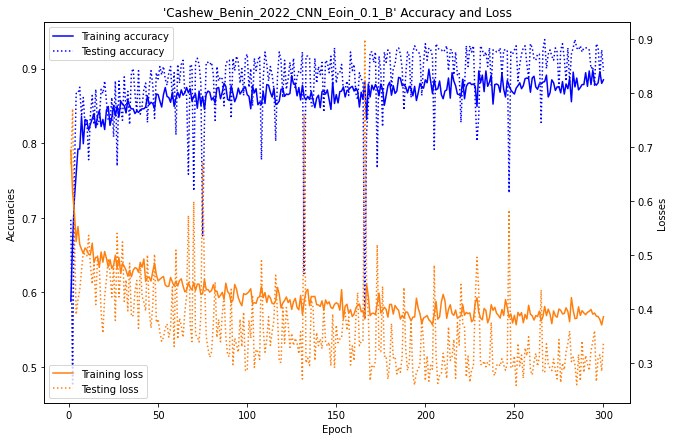

In [56]:
print(max(acc_c),max(val_acc_c))

fig, ax1 = plt.subplots(figsize=(10.5,7))
ax1.set_title(f"'{modelName_c}' Accuracy and Loss")

ax2 = ax1.twinx()
ax1.plot(epochs, acc_c, 'b-',label='Training accuracy')
ax1.plot(epochs, val_acc_c, 'b:', label='Testing accuracy')
ax2.plot(epochs, loss_c, '-', label='Training loss', color='tab:orange')
ax2.plot(epochs, val_loss_c, ':', label='Testing loss', color='tab:orange')

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracies")
ax2.set_ylabel("Losses")

ax1.legend(loc=2)
ax2.legend(loc=3)

plt.savefig(f'{modelName_c}.png')

Saved and reloaded: Cashew_Benin_2022_CNN_Eoin_0.1_B
6/6 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0     0.9664    0.9474    0.9568       152
         1.0     0.7500    0.8276    0.7869        29

    accuracy                         0.9282       181
   macro avg     0.8582    0.8875    0.8718       181
weighted avg     0.9318    0.9282    0.9296       181

Kappa	0.7438


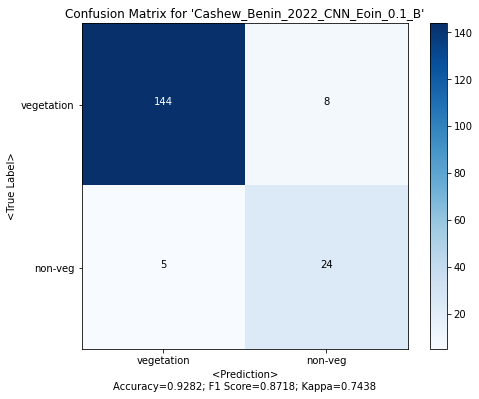

In [57]:
model_v = load_model(f"{modelName_c}_bestweights.hdf5")
print('Saved and reloaded:', modelName_c)

predictions = model_v.predict(xVal, verbose=1)
#predictions = model_c.predict(xVal, verbose=1)

classification = []
for row in predictions:
    classification.append( np.round(row) ) 
y_predicted = np.array(classification)

plot_confusion_matrix(yVal_c, y_predicted, target_names=classes_b, filename=modelName_c, normalize=0, save=1)

## Level C0: Fine Multiclass Classifier for "Crop"

In [58]:
xTrain_f0 = np.array(xTrain_f0)
xTest_f0  = np.array(xTest_f0)
xVal_f0   = np.array(xVal_f0)

yTrain_f0 = np.array(yTrain_f0)
yTest_f0  = np.array(yTest_f0)
yVal_f0   = np.array(yVal_f0)

In [59]:
num_classes_f0 = len(np.unique(yTrain_f0))
class_weights_f0 = compute_class_weight('balanced', np.unique(yTrain_f0), yTrain_f0)
class_weights_f0 = {i : class_weights_f0[i] for i in range(num_classes_f0)}
print("\nClass Weights:")
pprint.pprint(class_weights_f0)


Class Weights:
{0: 0.7277856135401974, 1: 1.5975232198142415}


C:\Users\eoin\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [60]:
#subver = 1

modelName_f0 = f"{root}_{ver}.{subver}_C0"
modelpath_f0 = f"{modelName_f0}_bestweights.hdf5"

checkpoint_f0 = ModelCheckpoint(modelpath_f0, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_f0 = [checkpoint_f0]

In [61]:
############### Binary Model (use one) ####################

model_f0 = Sequential()

model_f0.add(Conv1D(64, 3, activation='relu', input_shape=xTrain.shape[1:]))
model_f0.add(Dropout(0.3))

model_f0.add(Conv1D(32, 3, activation='relu'))
model_f0.add(Dropout(0.3))

model_f0.add(Flatten())

model_f0.add(Dense(64, activation='relu'))
model_f0.add(Dropout(0.3))

model_f0.add(Dense(32, activation='relu'))
model_f0.add(Dropout(0.3))

model_f0.add(Dense(1, activation='sigmoid'))


model_f0.compile(loss='binary_crossentropy',
         optimizer=Adam(learning_rate = 1e-3, decay = 1e-5),
         metrics=['accuracy'])
#model_f0.summary()

In [ ]:
############### Multiclass Model (use one) ####################

model_f0 = Sequential()

model_f0.add(Conv1D(64, 3, activation='relu', input_shape=xTrain.shape[1:]))
model_f0.add(Dropout(0.3))

model_f0.add(Conv1D(32, 3, activation='relu'))
model_f0.add(Dropout(0.3))

model_f0.add(Flatten())

model_f0.add(Dense(64, activation='relu'))
model_f0.add(Dropout(0.3))

model_f0.add(Dense(32, activation='relu'))
model_f0.add(Dropout(0.3))

model_f0.add(Dense(num_classes, activation='softmax'))


model_f0.compile(loss='sparse_categorical_crossentropy',
         optimizer=Adam(learning_rate = 1e-3, decay = 1e-5),
         metrics=['accuracy'])
#model_f0.summary()

In [66]:
a = input(f"Press enter to start model run, enter 'stop' to prevent start. Save parameters to '{modelName_f0}'?\n")

if a != 'stop':
    
    history_f0 = model_f0.fit(xTrain_f0, yTrain_f0, epochs=100, 
          #batch_size = 256,
          validation_data=(xTest_f0, yTest_f0), 
          callbacks=callbacks_list_f0,
          class_weight=class_weights_f0)
else:
    print("...Stopped!")

Press enter to start model run, enter 'stop' to prevent start. Save parameters to 'Cashew_Benin_2022_CNN_Eoin_0.1_C0'?

Epoch 1/100
12/33 [=========>....................] - ETA: 0s - loss: 0.2392 - accuracy: 0.9089
Epoch 00001: val_accuracy did not improve from 0.93706
33/33 [==============================] - 0s 5ms/step - loss: 0.2129 - accuracy: 0.9196 - val_loss: 0.2012 - val_accuracy: 0.9231
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2408 - accuracy: 0.9212
Epoch 00002: val_accuracy did not improve from 0.93706
33/33 [==============================] - 0s 3ms/step - loss: 0.2318 - accuracy: 0.9186 - val_loss: 0.1929 - val_accuracy: 0.9161
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2090 - accuracy: 0.9176
Epoch 00003: val_accuracy did not improve from 0.93706
33/33 [==============================] - 0s 3ms/step - loss: 0.2164 - accuracy: 0.9157 - val_loss: 0.3643 - val_accuracy: 0.8462
Epoch 4/100
22/33 [===================>....

Epoch 30/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2061 - accuracy: 0.9196
Epoch 00030: val_accuracy did not improve from 0.93706
33/33 [==============================] - 0s 3ms/step - loss: 0.2186 - accuracy: 0.9186 - val_loss: 0.1984 - val_accuracy: 0.9266
Epoch 31/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2422 - accuracy: 0.9137
Epoch 00031: val_accuracy did not improve from 0.93706
33/33 [==============================] - 0s 3ms/step - loss: 0.2343 - accuracy: 0.9147 - val_loss: 0.2845 - val_accuracy: 0.8951
Epoch 32/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2133 - accuracy: 0.9190
Epoch 00032: val_accuracy did not improve from 0.93706
33/33 [==============================] - 0s 3ms/step - loss: 0.2097 - accuracy: 0.9196 - val_loss: 0.2082 - val_accuracy: 0.9266
Epoch 33/100
20/33 [=================>............] - ETA: 0s - loss: 0.2313 - accuracy: 0.8984
Epoch 00033: val_accuracy did not improve from 0.93706
33/33 [==

23/33 [===================>..........] - ETA: 0s - loss: 0.2130 - accuracy: 0.9280
Epoch 00059: val_accuracy did not improve from 0.93706
33/33 [==============================] - 0s 3ms/step - loss: 0.2151 - accuracy: 0.9234 - val_loss: 0.2485 - val_accuracy: 0.9056
Epoch 60/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1806 - accuracy: 0.9310
Epoch 00060: val_accuracy did not improve from 0.93706
33/33 [==============================] - 0s 3ms/step - loss: 0.2055 - accuracy: 0.9302 - val_loss: 0.2599 - val_accuracy: 0.8986
Epoch 61/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2220 - accuracy: 0.9128
Epoch 00061: val_accuracy did not improve from 0.93706
33/33 [==============================] - 0s 3ms/step - loss: 0.2103 - accuracy: 0.9186 - val_loss: 0.2386 - val_accuracy: 0.9196
Epoch 62/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2443 - accuracy: 0.8995
Epoch 00062: val_accuracy did not improve from 0.93706
33/33 [===============

23/33 [===================>..........] - ETA: 0s - loss: 0.2162 - accuracy: 0.9212
Epoch 00088: val_accuracy did not improve from 0.93706
33/33 [==============================] - 0s 3ms/step - loss: 0.2091 - accuracy: 0.9225 - val_loss: 0.2151 - val_accuracy: 0.9126
Epoch 89/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1905 - accuracy: 0.9321
Epoch 00089: val_accuracy did not improve from 0.93706
33/33 [==============================] - 0s 3ms/step - loss: 0.1970 - accuracy: 0.9283 - val_loss: 0.2783 - val_accuracy: 0.8951
Epoch 90/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2234 - accuracy: 0.9062
Epoch 00090: val_accuracy did not improve from 0.93706
33/33 [==============================] - 0s 3ms/step - loss: 0.2172 - accuracy: 0.9138 - val_loss: 0.2189 - val_accuracy: 0.9231
Epoch 91/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1995 - accuracy: 0.9293
Epoch 00091: val_accuracy did not improve from 0.93706
33/33 [===============

In [67]:
### RUN CELL ONCE ONLY PER MODEL RUN ###          
# this cell allows the history from the current run to be appended to the histories of previous runs for plotting

#acc_f0,val_acc_f0,loss_f0,val_loss_f0 = [],[],[],[]   # unhash this for the first run of the above cell block only

acc_f0.append(history_f0.history['accuracy'])
val_acc_f0.append(history_f0.history['val_accuracy'])
loss_f0.append(history_f0.history['loss'])
val_loss_f0.append(history_f0.history['val_loss'])

acc_f0 = flatten(acc_f0)
val_acc_f0 = flatten(val_acc_f0)
loss_f0 = flatten(loss_f0)
val_loss_f0 = flatten(val_loss_f0)

epochs = np.array(range(len(acc_f0))) + 1

np.save(f'cache/{modelName_f0}_acc.npy', acc_f0)
np.save(f'cache/{modelName_f0}_vacc.npy', val_acc_f0)
np.save(f'cache/{modelName_f0}_loss.npy', loss_f0)
np.save(f'cache/{modelName_f0}_vloss.npy', val_loss_f0)

0.9350775480270386 0.9370629191398621


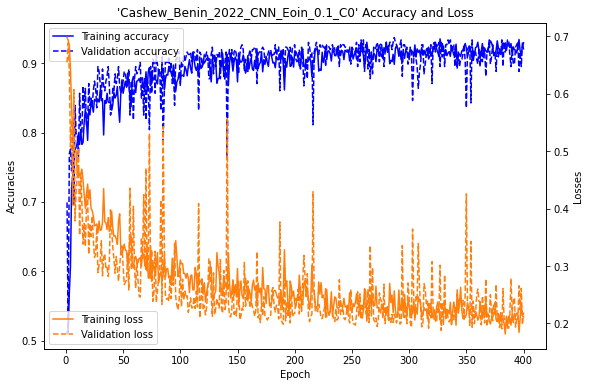

In [68]:
print(max(acc_f0),max(val_acc_f0))

fig, ax1 = plt.subplots(figsize=(9,6))
ax1.set_title(f"'{modelName_f0}' Accuracy and Loss")

ax2 = ax1.twinx()
ax1.plot(epochs, acc_f0,      'b-',  label='Training accuracy')
ax1.plot(epochs, val_acc_f0,  'b--', label='Validation accuracy')
ax2.plot(epochs, loss_f0,     '-',   label='Training loss', color='tab:orange')
ax2.plot(epochs, val_loss_f0, '--',  label='Validation loss', color='tab:orange')

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracies")
ax2.set_ylabel("Losses")

ax1.legend(loc=2)
ax2.legend(loc=3)

plt.savefig(f'{modelName_f0}.png')

Saved and reloaded: Cashew_Benin_2022_CNN_Eoin_0.1_C0
5/5 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         0.0     0.8901    0.9310    0.9101        87
         1.0     0.8966    0.8387    0.8667        62

    accuracy                         0.8926       149
   macro avg     0.8933    0.8849    0.8884       149
weighted avg     0.8928    0.8926    0.8920       149

Kappa	0.7769


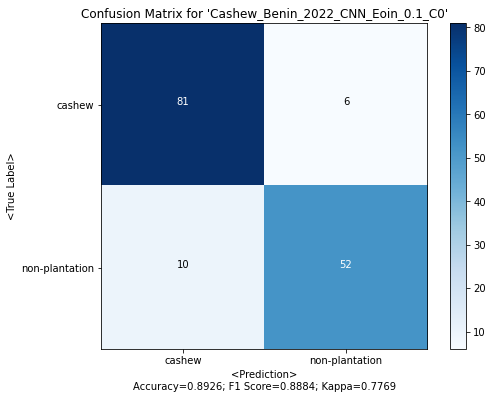

In [69]:
model_v = load_model(f"{modelName_f0}_bestweights.hdf5")
print('Saved and reloaded:', modelName_f0)

predictions = model_v.predict(xVal_f0, verbose=1)    # predicts using the best run
#predictions = model_f0.predict(xVal_f0, verbose=1)    # predicts using the final run

classification = []
for row in predictions:
    #classification.append( np.argmax(row) )    # multiclass
    classification.append( np.round(row) )     # binary
y_predicted = np.array(classification)

plot_confusion_matrix(yVal_f0, y_predicted, target_names=classes_c0, filename=modelName_f0, normalize=0, save=1)

## Level C1: Fine Multiclass Classifier for "Non-crop"

In [70]:
xTrain_f1 = np.array(xTrain_f1)
xTest_f1  = np.array(xTest_f1)
xVal_f1   = np.array(xVal_f1)

yTrain_f1 = np.array(yTrain_f1)
yTest_f1  = np.array(yTest_f1)
yVal_f1   = np.array(yVal_f1)

In [71]:
## ONLY RUN ONCE ##
yTrain_f1 -= num_classes_f0
yTest_f1  -= num_classes_f0
yVal_f1   -= num_classes_f0

In [72]:
num_classes_f1 = len(np.unique(yTrain_f1))
class_weights_f1 = compute_class_weight('balanced', np.unique(yTrain_f1), yTrain_f1)
class_weights_f1 = {i : class_weights_f1[i] for i in range(num_classes_f1)}
print("\nClass Weights:")
pprint.pprint(class_weights_f1)


Class Weights:
{0: 1.027027027027027, 1: 0.6909090909090909, 2: 1.7272727272727273}


C:\Users\eoin\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1. 2.], y=[2. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 2. 2. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0.
 2. 0. 0. 2. 2. 1. 2. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 2. 1. 0. 0.
 0. 1. 1. 1. 0. 1. 2. 1. 2. 0. 2. 0. 2. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 2.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 0. 0. 1. 2. 2. 1. 2. 1.
 0. 1. 1. 0. 2. 0. 1. 0. 2. 1. 1. 1. 1. 2. 1. 1. 0. 2. 0. 2. 1. 2. 0. 2.
 1. 0. 1. 0. 1. 2. 2. 2. 1. 0. 1. 1. 0. 0. 0. 1. 1. 2. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 1. 1. 1. 2. 1. 2. 2. 0. 2. 0. 0. 0. 0. 0. 2. 2. 1. 1.
 2. 1. 1. 0. 0. 0. 2. 1. 1. 0. 0. 1. 0. 2. 1. 1. 0. 1. 2. 1. 0. 1. 0. 0.
 2. 0. 1. 1. 2. 1. 0. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 0. 1. 2. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 0. 0. 0. 1. 1. 0.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [73]:
modelName_f1 = f"{root}_{ver}.{subver}_C1"
modelpath_f1 = f"{modelName_f1}_bestweights.hdf5"

checkpoint_f1 = ModelCheckpoint(modelpath_f1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_f1 = [checkpoint_f1]

In [ ]:
############### Binary Model (choose only one!) ####################

model_f1 = Sequential()

model_f1.add(Conv1D(64, 3, activation='relu', input_shape=xTrain.shape[1:]))
model_f1.add(Dropout(0.3))

model_f1.add(Conv1D(32, 3, activation='relu'))
model_f1.add(Dropout(0.3))

model_f1.add(Flatten())

model_f1.add(Dense(64, activation='relu'))
model_f1.add(Dropout(0.3))

model_f1.add(Dense(32, activation='relu'))
model_f1.add(Dropout(0.3))

model_f1.add(Dense(1, activation='sigmoid'))


model_f1.compile(loss='binary_crossentropy',
         optimizer=Adam(learning_rate = 1e-3, decay = 1e-5),
         metrics=['accuracy'])
#model_f1.summary()

In [74]:
############### Multiclass Model (choose only one!) ####################

model_f1 = Sequential()

model_f1.add(Conv1D(64, 3, activation='relu', input_shape=xTrain.shape[1:]))
model_f1.add(Dropout(0.3))

model_f1.add(Conv1D(32, 3, activation='relu'))
model_f1.add(Dropout(0.3))

model_f1.add(Flatten())

model_f1.add(Dense(64, activation='relu'))
model_f1.add(Dropout(0.3))

model_f1.add(Dense(32, activation='relu'))
model_f1.add(Dropout(0.3))

model_f1.add(Dense(num_classes_f1, activation='softmax'))


model_f1.compile(loss='sparse_categorical_crossentropy',
         optimizer=Adam(learning_rate = 1e-3, decay = 1e-5),
         metrics=['accuracy'])
#model_f1.summary()

In [79]:
a = input(f"Press enter to start model run, enter 'stop' to prevent start. Save parameters to '{modelName_f1}'?\n")

if a != 'stop':
    
    t1 = t.time()   # to measure runtime
    history_f1 = model_f1.fit(xTrain_f1, yTrain_f1, epochs=100, 
          #batch_size = 256,
          validation_data=(xTest_f1,yTest_f1), 
          callbacks=callbacks_list_f1,
          class_weight=class_weights_f1)
    t2 = t.time()
    t_del = t2 - t1
    
else:
    print("...Stopped!")

Press enter to start model run, enter 'stop' to prevent start. Save parameters to 'Cashew_Benin_2022_CNN_Eoin_0.1_C1'?

Epoch 1/100
1/8 [==>...........................] - ETA: 0s - loss: 0.6346 - accuracy: 0.5938
Epoch 00001: val_accuracy did not improve from 0.82432
8/8 [==============================] - 0s 9ms/step - loss: 0.5655 - accuracy: 0.6974 - val_loss: 0.5899 - val_accuracy: 0.7703
Epoch 2/100
1/8 [==>...........................] - ETA: 0s - loss: 0.5375 - accuracy: 0.7188
Epoch 00002: val_accuracy did not improve from 0.82432
8/8 [==============================] - 0s 5ms/step - loss: 0.5257 - accuracy: 0.7763 - val_loss: 0.7298 - val_accuracy: 0.6351
Epoch 3/100
1/8 [==>...........................] - ETA: 0s - loss: 0.4238 - accuracy: 0.7812
Epoch 00003: val_accuracy did not improve from 0.82432
8/8 [==============================] - 0s 5ms/step - loss: 0.5173 - accuracy: 0.6974 - val_loss: 0.5308 - val_accuracy: 0.7973
Epoch 4/100
1/8 [==>...........................] - ETA:

1/8 [==>...........................] - ETA: 0s - loss: 0.5167 - accuracy: 0.8438
Epoch 00030: val_accuracy did not improve from 0.82432
8/8 [==============================] - 0s 4ms/step - loss: 0.5736 - accuracy: 0.7237 - val_loss: 0.7355 - val_accuracy: 0.6622
Epoch 31/100
1/8 [==>...........................] - ETA: 0s - loss: 0.4646 - accuracy: 0.7188
Epoch 00031: val_accuracy did not improve from 0.82432
8/8 [==============================] - 0s 4ms/step - loss: 0.5459 - accuracy: 0.7368 - val_loss: 0.4992 - val_accuracy: 0.7838
Epoch 32/100
1/8 [==>...........................] - ETA: 0s - loss: 0.6033 - accuracy: 0.7812
Epoch 00032: val_accuracy did not improve from 0.82432
8/8 [==============================] - 0s 4ms/step - loss: 0.5165 - accuracy: 0.7851 - val_loss: 0.8319 - val_accuracy: 0.6486
Epoch 33/100
1/8 [==>...........................] - ETA: 0s - loss: 0.5601 - accuracy: 0.6562
Epoch 00033: val_accuracy did not improve from 0.82432
8/8 [==============================]

Epoch 60/100
1/8 [==>...........................] - ETA: 0s - loss: 0.6714 - accuracy: 0.7188
Epoch 00060: val_accuracy did not improve from 0.82432
8/8 [==============================] - 0s 4ms/step - loss: 0.4962 - accuracy: 0.7851 - val_loss: 0.7673 - val_accuracy: 0.6622
Epoch 61/100
1/8 [==>...........................] - ETA: 0s - loss: 0.5979 - accuracy: 0.5938
Epoch 00061: val_accuracy did not improve from 0.82432
8/8 [==============================] - 0s 4ms/step - loss: 0.4721 - accuracy: 0.7544 - val_loss: 0.5239 - val_accuracy: 0.8108
Epoch 62/100
1/8 [==>...........................] - ETA: 0s - loss: 0.7071 - accuracy: 0.6875
Epoch 00062: val_accuracy did not improve from 0.82432
8/8 [==============================] - 0s 4ms/step - loss: 0.6572 - accuracy: 0.7412 - val_loss: 1.0623 - val_accuracy: 0.5270
Epoch 63/100
1/8 [==>...........................] - ETA: 0s - loss: 0.6627 - accuracy: 0.6875
Epoch 00063: val_accuracy did not improve from 0.82432
8/8 [==================

Epoch 90/100
1/8 [==>...........................] - ETA: 0s - loss: 0.5052 - accuracy: 0.8438
Epoch 00090: val_accuracy did not improve from 0.82432
8/8 [==============================] - 0s 6ms/step - loss: 0.4782 - accuracy: 0.7763 - val_loss: 0.5525 - val_accuracy: 0.7973
Epoch 91/100
1/8 [==>...........................] - ETA: 0s - loss: 0.4484 - accuracy: 0.7500
Epoch 00091: val_accuracy did not improve from 0.82432
8/8 [==============================] - 0s 5ms/step - loss: 0.4672 - accuracy: 0.7632 - val_loss: 0.5550 - val_accuracy: 0.7568
Epoch 92/100
1/8 [==>...........................] - ETA: 0s - loss: 0.5074 - accuracy: 0.7500
Epoch 00092: val_accuracy did not improve from 0.82432
8/8 [==============================] - 0s 5ms/step - loss: 0.4450 - accuracy: 0.7895 - val_loss: 0.5617 - val_accuracy: 0.7297
Epoch 93/100
1/8 [==>...........................] - ETA: 0s - loss: 0.4169 - accuracy: 0.8438
Epoch 00093: val_accuracy did not improve from 0.82432
8/8 [==================

In [80]:
### RUN CELL ONCE ONLY PER MODEL RUN ###          
# this cell allows the history from the current run to be appended to the histories of previous runs for plotting

#acc_f1,val_acc_f1,loss_f1,val_loss_f1,t_tot = [],[],[],[],0  # For the plot, unhash to wipe previous Layer runs, hash to keep

t_tot += t_del    # aggregates runtime over all runs of this subver of this model.

acc_f1.append(history_f1.history['accuracy'])
val_acc_f1.append(history_f1.history['val_accuracy'])
loss_f1.append(history_f1.history['loss'])
val_loss_f1.append(history_f1.history['val_loss'])

acc_f1 = flatten(acc_f1)
val_acc_f1 = flatten(val_acc_f1)
loss_f1 = flatten(loss_f1)
val_loss_f1 = flatten(val_loss_f1)

epochs = np.array(range(len(acc_f1))) + 1

np.save(f'{modelName_f1}_acc.npy', acc_f1)
np.save(f'{modelName_f1}_vacc.npy', val_acc_f1)
np.save(f'{modelName_f1}_loss.npy', loss_f1)
np.save(f'{modelName_f1}_vloss.npy', val_loss_f1)

runtime: 21.452762365341187 
 0.8421052694320679 0.8243243098258972


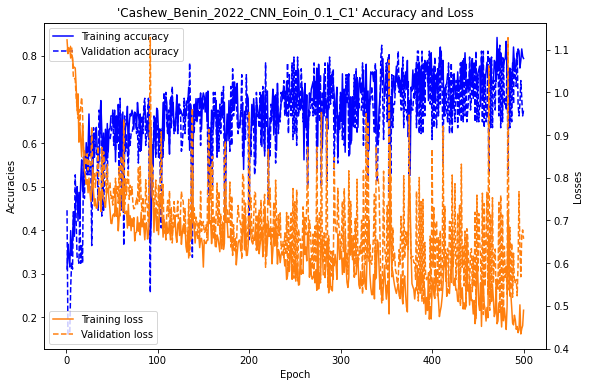

In [81]:
print('runtime:', t_tot, '\n',max(acc_f1),max(val_acc_f1))

fig, ax1 = plt.subplots(figsize=(9,6))
ax1.set_title(f"'{modelName_f1}' Accuracy and Loss")

ax2 = ax1.twinx()
ax1.plot(epochs, acc_f1,      'b-',  label='Training accuracy')
ax1.plot(epochs, val_acc_f1,  'b--', label='Validation accuracy')
ax2.plot(epochs, loss_f1,     '-',   label='Training loss', color='tab:orange')
ax2.plot(epochs, val_loss_f1, '--',  label='Validation loss', color='tab:orange')

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracies")
ax2.set_ylabel("Losses")

ax1.legend(loc=2)
ax2.legend(loc=3)

plt.savefig(f'{modelName_f1}.png')

              precision    recall  f1-score   support

           0     0.8462    0.9167    0.8800        12
           1     0.8571    0.9231    0.8889        13
           2     1.0000    0.7143    0.8333         7

    accuracy                         0.8750        32
   macro avg     0.9011    0.8513    0.8674        32
weighted avg     0.8843    0.8750    0.8734        32

Kappa	0.8034


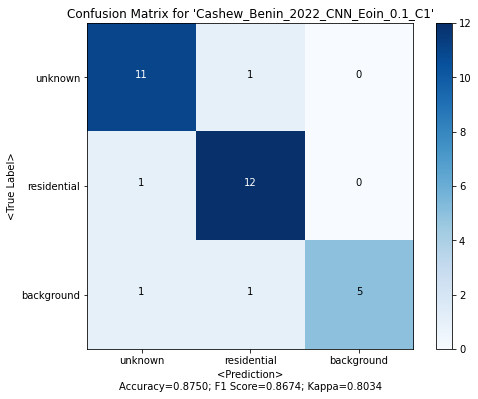

In [82]:
model_v = load_model(f"{modelName_f1}_bestweights.hdf5")
predictions = model_v(xVal_f1)
#predictions = model_f1(xVal_f1)

classification = []
for row in predictions:
    #classification.append( np.round(row) )    # for binary
    classification.append( np.argmax(row) )    # for multiclass
y_predicted = np.array(classification)

plot_confusion_matrix(yVal_f1, y_predicted, target_names=classes_c1, filename=modelName_f1, normalize=0, save=1)

## Validation of whole hierarchy at once

#### Need to run through steps 1-10 of data processing above before this will work

In [83]:
#root = 'ICLR_Kenya_RNN_Eoin'
#subver = 1  # choose which models and sub-versions to load
#num_classes_f0 = 2

model_vc  = load_model(f"{root}_{ver}.{subver}_B_bestweights.hdf5")
model_vf0 = load_model(f"{root}_{ver}.{subver}_C0_bestweights.hdf5")
model_vf1 = load_model(f"{root}_{ver}.{subver}_C1_bestweights.hdf5")

### Testing Dataset

(360, 17, 12) (360,)
[0. 1.] [2. 3. 4.] 

              precision    recall  f1-score   support

         0.0     0.9400    0.9216    0.9307       204
         1.0     0.8721    0.7979    0.8333        94
         2.0     0.8421    0.8889    0.8649        18
         3.0     0.7907    0.8293    0.8095        41
         4.0     0.0833    0.3333    0.1333         3

    accuracy                         0.8722       360
   macro avg     0.7056    0.7542    0.7143       360
weighted avg     0.8932    0.8722    0.8815       360

Kappa	0.7892


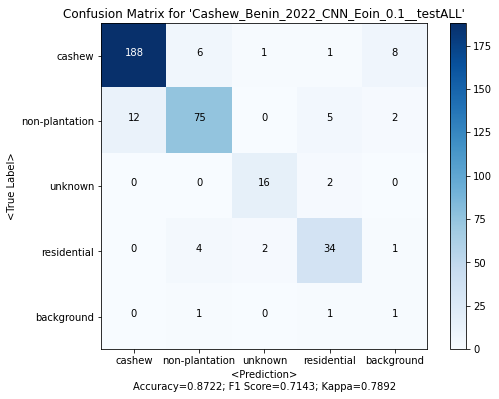

In [84]:
print(xTest.shape, yTest.shape)
print(np.unique(yTest)[:num_classes_f0],np.unique(yTest)[num_classes_f0:],'\n')

predictions = []

for i in range(len(yTest)):
    data = np.reshape( xTest[i], (1, 17, num_bands) )
    coarse = np.round( model_vc(data) )
    
    if coarse == 0.:
        if num_classes_f0 == 2:       # binary model
            fine = np.round( model_vf0(data) )
            predictions.append(fine[0][0])
        else:                         # multiclass model
            fine = np.argmax( model_vf0(data) )
            predictions.append(fine)
    
    elif coarse == 1.:
        fine = np.argmax( model_vf1(data) ) + num_classes_f0
        predictions.append(fine)
        
    else:
        raise ValueError('Error! Prediction output should be 0. or 1.\n')
        
        
modelName = f'{root}_{ver}.{subver}__testALL'
plot_confusion_matrix(yTest, predictions, target_names=classes, filename=modelName, normalize=0, save=1)

### Validation Dataset

(181, 17, 12) (181,)
[0. 1.] [2. 3. 4.] 

              precision    recall  f1-score   support

         0.0     0.8791    0.8791    0.8791        91
         1.0     0.8276    0.7869    0.8067        61
         2.0     0.7692    0.9091    0.8333        11
         3.0     0.8571    0.7500    0.8000        16
         4.0     0.0000    0.0000    0.0000         2

    accuracy                         0.8287       181
   macro avg     0.6666    0.6650    0.6638       181
weighted avg     0.8434    0.8287    0.8352       181

Kappa	0.7272


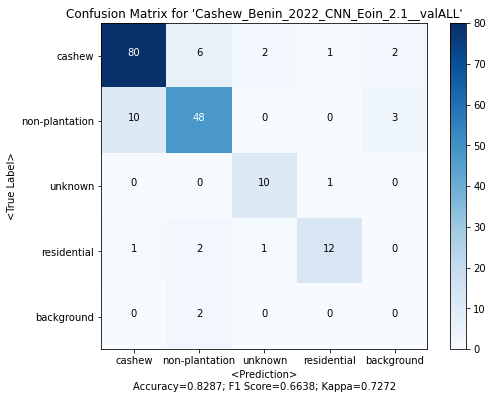

In [85]:
print(xVal.shape, yVal.shape)
print(np.unique(yVal)[:num_classes_f0],np.unique(yVal)[num_classes_f0:],'\n')

predictions = []

for i in range(len(yVal)):
    data = np.reshape( xVal[i], (1, 17, num_bands) )
    coarse = np.round( model_vc(data) )
    
    if coarse == 0.:
        if num_classes_f0 == 2:       # binary model
            fine = np.round( model_vf0(data) )
            predictions.append(fine[0][0])
        else:                         # multiclass model
            fine = np.argmax( model_vf0(data) )
            predictions.append(fine)
    
    elif coarse == 1.:
        fine = np.argmax( model_vf1(data) ) + num_classes_f0
        predictions.append(fine)
        
    else:
        raise ValueError('Error! Prediction output should be 0. or 1.\n')
        
        
modelName = f'{root}_2.{subver}__valALL'
plot_confusion_matrix(yVal, predictions, target_names=classes, filename=modelName, normalize=0, save=1)